In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [3]:
market = pd.read_csv('estaticos_market.csv')
market.drop('Unnamed: 0', axis=1, inplace=True)

# multiple tables shouldn't have redundant data, so only company ids are kept from portifolio
companies = [pd.read_csv('estaticos_portfolio1.csv')['id'],
            pd.read_csv('estaticos_portfolio2.csv')['id'],
            pd.read_csv('estaticos_portfolio3.csv')['id']]


print(market.info())
for comp in companies:
    print(comp.size)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462298 entries, 0 to 462297
Columns: 181 entries, id to qt_filiais
dtypes: bool(9), float64(144), int64(1), object(27)
memory usage: 610.6+ MB
None
555
566
265


In [4]:
# Como existem muitas colunas, podemos remover aquelas com um número elevado de observações faltantes.
for col in market.columns:
    if market[col].isna().sum()/market[col].size >= 0.9:
        market.drop(col, axis=1, inplace=True)

In [5]:
#inspect object columns
obj_df = market.select_dtypes(exclude = 'number')
#print(obj_df.head())
for col in obj_df.columns:
    market[col].fillna(value='NA', inplace=True)
    print(col, obj_df[col].value_counts().size)
    

id 462298
fl_matriz 2
de_natureza_juridica 67
sg_uf 6
natureza_juridica_macro 7
de_ramo 33
setor 5
idade_emp_cat 6
fl_me 2
fl_sa 2
fl_epp 1
fl_mei 2
fl_ltda 2
dt_situacao 7334
fl_st_especial 2
fl_email 2
fl_telefone 2
fl_rm 2
nm_divisao 87
nm_segmento 21
fl_spa 2
fl_antt 2
fl_veiculo 2
fl_optante_simples 2
fl_optante_simei 2
sg_uf_matriz 27
de_saude_tributaria 6
de_saude_rescencia 5
de_nivel_atividade 4
fl_simples_irregular 2
nm_meso_regiao 19
nm_micro_regiao 73
fl_passivel_iss 2
de_faixa_faturamento_estimado 12
de_faixa_faturamento_estimado_grupo 11


A maioria das colunas não-numéricas possuem cardinalidade abiaxo de 100, valores relativamete pequenos, mas que sugerem a impossibilidade de usar one-hot encoding. Umas das colunas se destaca com o número de itens (dt_situacao), que provavelmente pode ser descartada para evitar overfitting.

In [6]:
num_df = market.select_dtypes(include = 'number')

inputer = SimpleImputer(strategy = 'median', verbose=1)
filled_array = inputer.fit_transform(num_df)
num_df = pd.DataFrame(filled_array, columns=num_df.columns, index=num_df.index)

for col in num_df.columns:
    if num_df[col].var() < 0.1:
        num_df.drop(col, axis=1, inplace=True)

In [7]:
df = pd.concat((obj_df, num_df), axis=1)

In [8]:
df.set_index(df['id'],inplace=True)
df.drop('id', axis=1, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 462298 entries, a6984c3ae395090e3bee8ad63c3758b110de096d5d819583a784a113726db849 to 3d43e934e150b86be1e67524f5ba1018b27da9ef25566d9c0607623ae7f25e3a
Columns: 105 entries, fl_matriz to qt_filiais
dtypes: bool(9), float64(71), object(25)
memory usage: 346.1+ MB


In [34]:
from catboost import CatBoostClassifier, CatBoostRegressor
cat = CatBoostRegressor(silent=True, iterations=200, max_depth = 5)

In [35]:
def train_classifier(classifier, client_list):
    market_clients = market.set_index('id')
    market_clients['is_client'] = 0
    market_clients.loc[client_list.array, 'is_client'] = 1
    target = market_clients['is_client']
    features = market_clients.drop('is_client', axis=1)
    cat_columns = features.select_dtypes(exclude = 'number').columns
    classifier.fit(features, target, cat_features=cat_columns)
    
train_classifier(cat, companies[1])
    

In [12]:
def get_proba(classifier, client_list):
    prospects = market.set_index('id')
    prospects['is_client'] = 0
    prospects.loc[client_list.array, 'is_client'] = 1
    prospects = prospects[prospects['is_client'] == 0]
    prospects.drop('is_client', axis=1, inplace=True)
    #cat_columns = prospects.select_dtypes(exclude = 'number').columns
    return classifier.predict_proba(prospects)

proba = get_proba(cat, companies[1])

In [37]:
def get_predict(classifier, client_list):
    prospects = market.set_index('id')
    prospects['is_client'] = 0
    prospects.loc[client_list.array, 'is_client'] = 1
    prospects = prospects[prospects['is_client'] == 0]
    prospects.drop('is_client', axis=1, inplace=True)
    #cat_columns = prospects.select_dtypes(exclude = 'number').columns
    return classifier.predict(prospects)

predict = get_predict(cat, companies[1])

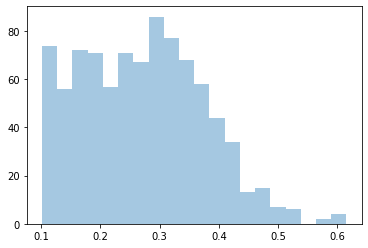

In [42]:
sns.distplot(predict[(predict>0.1) &(predict<1)], bins = 20, kde=False)

In [14]:
(proba[:,1]>0.5).sum()

870

In [43]:
cat.get_feature_importance(prettified=True)

,Feature Id,Importances
0,vl_faturamento_estimado_aux,28.741396
1,fl_matriz,8.500987
2,idade_emp_cat,5.433563
3,grau_instrucao_macro_escolaridade_media,4.644824
4,idade_empresa_anos,3.825163
5,qt_funcionarios_grupo,3.236729
6,de_faixa_faturamento_estimado,2.966394
7,qt_funcionarios_12meses,2.792489
8,qt_funcionarios_24meses,2.681807
9,qt_funcionarios,2.367398


In [46]:
import shap

def get_shap(classifier, client_list):
    prospects = market.set_index('id')
    prospects['is_client'] = 0
    prospects.loc[client_list.array, 'is_client'] = 1
    prospects = prospects[prospects['is_client'] == 0]
    prospects.drop('is_client', axis=1, inplace=True)
    explainer = shap.TreeExplainer(cat)
    return explainer.shap_values(prospects)

explainer = shap.TreeExplainer(cat)
shap_values = get_shap(cat, companies[1])

In [47]:
prospects = market.set_index('id')
prospects['is_client'] = 0
prospects.loc[companies[1].array, 'is_client'] = 1
prospects = prospects[prospects['is_client'] == 0]
prospects.drop('is_client', axis=1, inplace=True)
shap.force_plot(explainer.expected_value, shap_values[0,:], prospects.iloc[0,:], matplotlib=True)

TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

In [49]:
prospects.iloc[0,:]

fl_matriz                                                                  True
de_natureza_juridica                              SOCIEDADE EMPRESARIA LIMITADA
sg_uf                                                                        RN
natureza_juridica_macro                                  ENTIDADES EMPRESARIAIS
de_ramo                                                 INDUSTRIA DA CONSTRUCAO
setor                                                          CONSTRUÇÃO CIVIL
idade_empresa_anos                                                      14.4575
idade_emp_cat                                                           10 a 15
fl_me                                                                     False
fl_sa                                                                     False
fl_epp                                                                    False
fl_mei                                                                    False
fl_ltda                                 

In [53]:
shap_values.shape

(461732, 122)